## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from scripts_step_lr_schedulers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
# Unzip files
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/fold_1.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/fold_2.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/fold_3.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/fold_4.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/fold_5.tar.gz

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,validation,train,train


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 96,
  'BATCH_SIZE': 32,
  'EPOCHS': 4,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 4,
  'N_FOLDS': 5,
  "question_size": 4,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1e-06


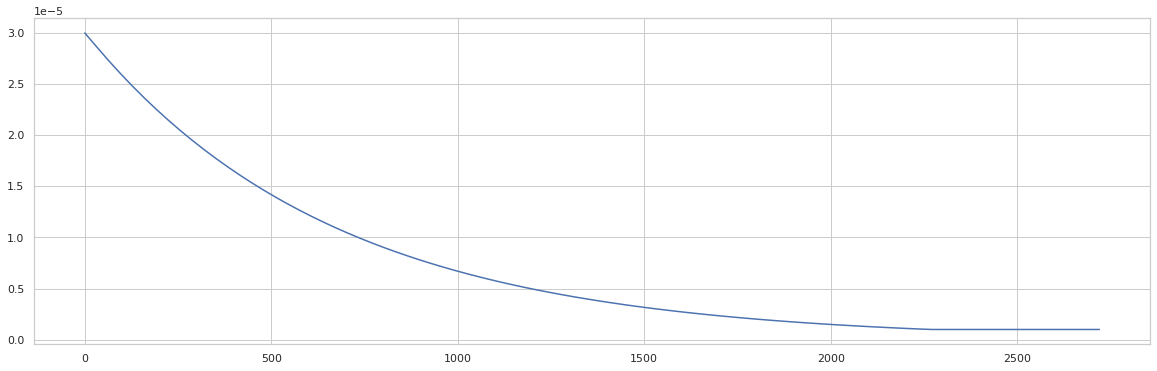

In [6]:
lr_min = 1e-6
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
decay = .9985

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x = layers.LSTM(128, return_sequences=True)(last_hidden_state)
    x = layers.Dropout(.1)(x)
    
    x_start = layers.TimeDistributed(layers.Dense(1))(x)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)
    
    x_end = layers.TimeDistributed(layers.Dense(1))(x)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=1, lr_start=lr_max, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(),
                                   'y_end': losses.CategoricalCrossentropy()})
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=False, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        validation_steps=valid_step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)
    model.save_weights('last_' + model_path)
    
    # Make predictions (last model)
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])

    # Make predictions (best model)
    model.load_weights(model_path)
    predict_eval_df(k_fold_best, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])
    
    ### Delete data dir
    shutil.rmtree(base_data_path)


FOLD: 1
Train for 687 steps, validate for 171 steps
Epoch 1/4
687/687 - 291s - loss: 2.1266 - y_start_loss: 1.0577 - y_end_loss: 1.0689 - val_loss: 1.6347 - val_y_start_loss: 0.8348 - val_y_end_loss: 0.7998
Epoch 2/4
687/687 - 274s - loss: 1.6108 - y_start_loss: 0.8239 - y_end_loss: 0.7869 - val_loss: 1.5653 - val_y_start_loss: 0.8187 - val_y_end_loss: 0.7466
Epoch 3/4
687/687 - 274s - loss: 1.4956 - y_start_loss: 0.7769 - y_end_loss: 0.7187 - val_loss: 1.5594 - val_y_start_loss: 0.8158 - val_y_end_loss: 0.7436
Epoch 4/4
687/687 - 274s - loss: 1.4597 - y_start_loss: 0.7651 - y_end_loss: 0.6947 - val_loss: 1.5543 - val_y_start_loss: 0.8111 - val_y_end_loss: 0.7432

FOLD: 2
Train for 687 steps, validate for 171 steps
Epoch 1/4
687/687 - 289s - loss: 2.1940 - y_start_loss: 1.0765 - y_end_loss: 1.1175 - val_loss: 1.7291 - val_y_start_loss: 0.8774 - val_y_end_loss: 0.8516
Epoch 2/4
687/687 - 275s - loss: 1.6074 - y_start_loss: 0.8277 - y_end_loss: 0.7797 - val_loss: 1.6538 - val_y_start_lo

# Model loss graph

Fold: 1


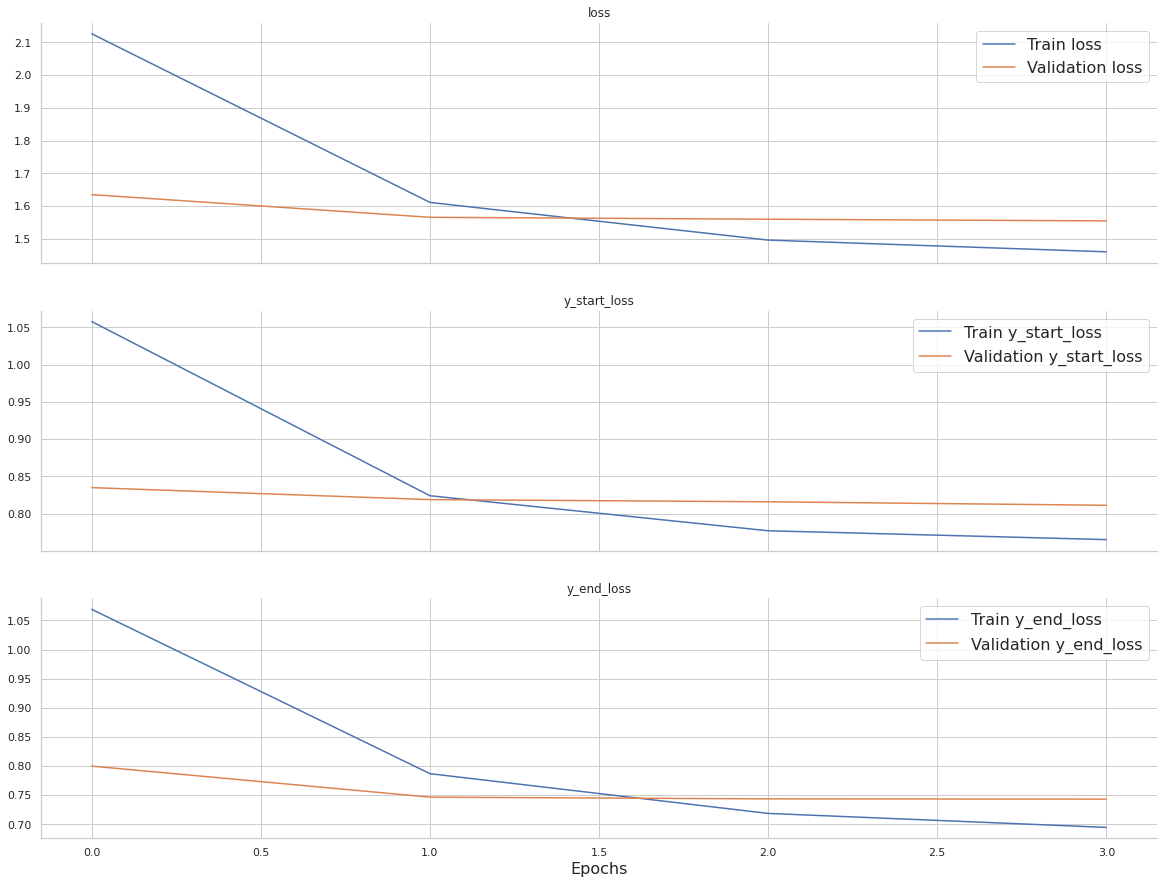

Fold: 2


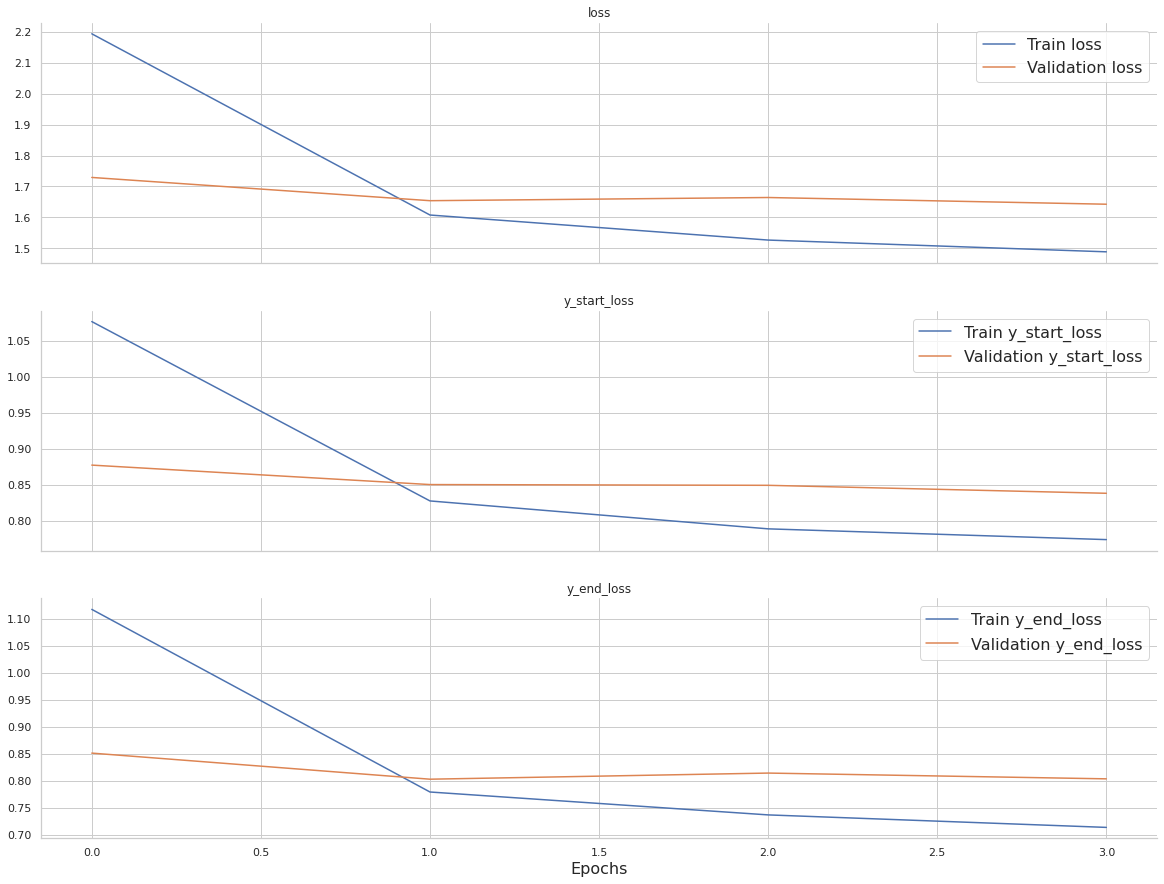

Fold: 3


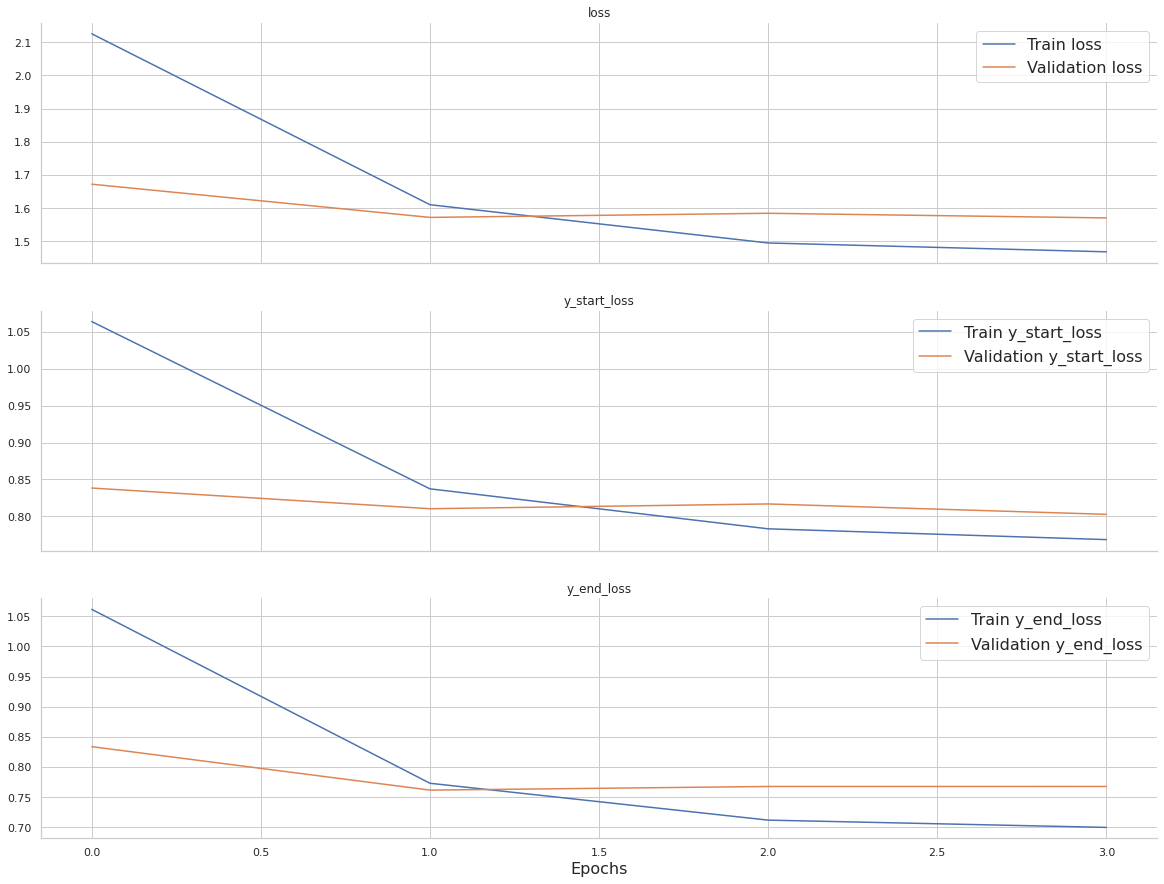

Fold: 4


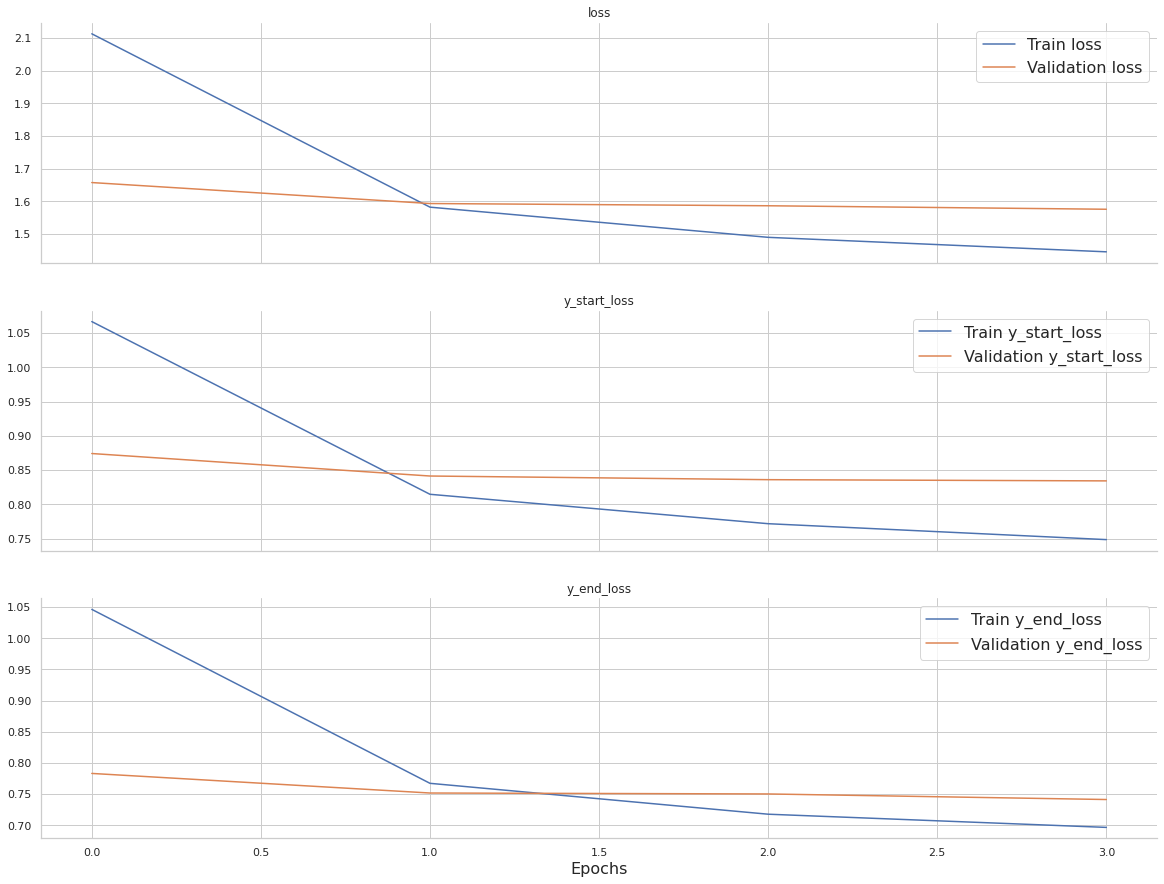

Fold: 5


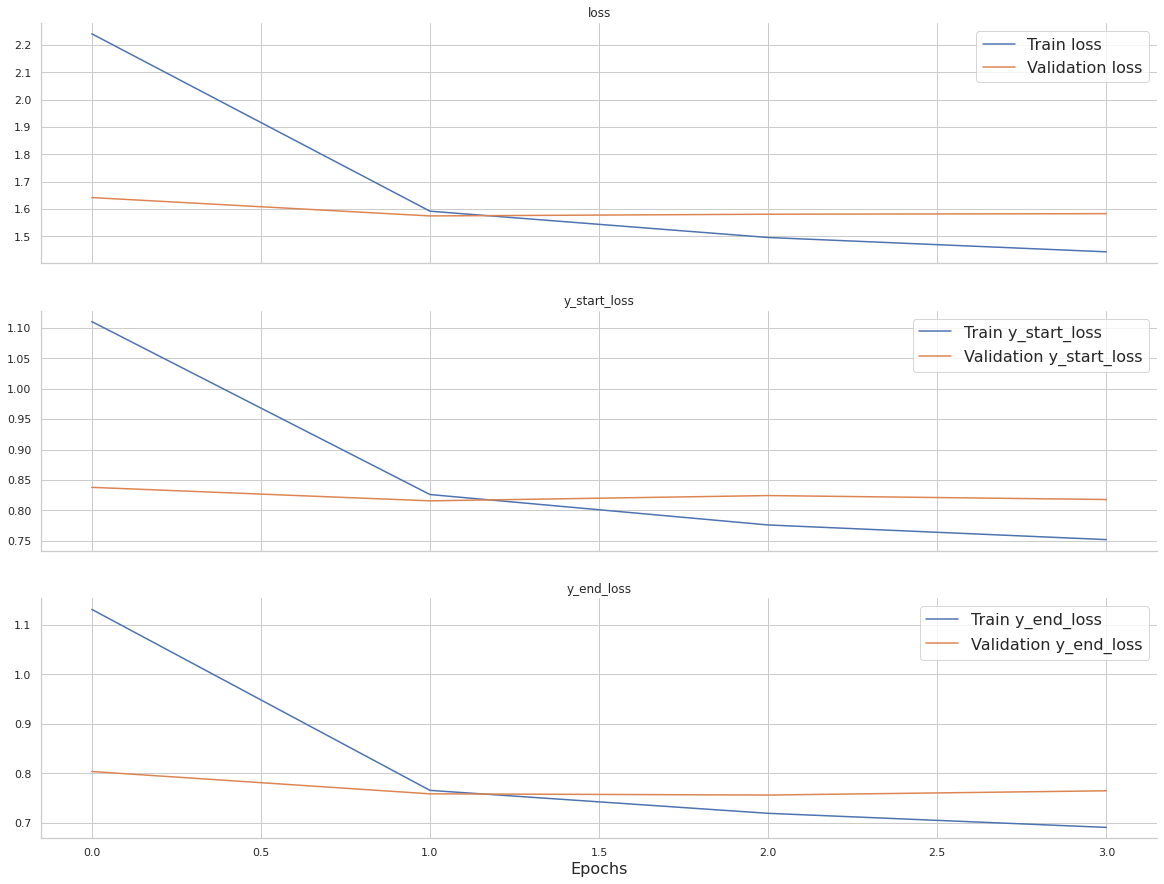

In [9]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation (best model)

In [10]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.731912,0.704254,0.027657,0.734762,0.709579,0.732183,0.699577,0.730468,0.706798,0.736862,0.700365,0.725282,0.704951
Sentiment negative,0.570703,0.521020,0.049683,0.576233,0.518347,0.570283,0.512595,0.569411,0.523406,0.576421,0.526513,0.561167,0.524239
Sentiment neutral,0.974813,0.973345,0.001468,0.975123,0.973878,0.974933,0.972765,0.974447,0.974912,0.975476,0.971479,0.974087,0.973692
Sentiment positive,0.563422,0.521812,0.041610,0.567171,0.540440,0.564554,0.515065,0.560423,0.525869,0.573206,0.506906,0.551757,0.520781
0 <= text wordCnt < 3,0.861981,0.853970,0.008011,0.866841,0.828358,0.860661,0.849890,0.861543,0.864829,0.867576,0.835470,0.853286,0.891304
3 <= text wordCnt < 10,0.785556,0.764449,0.021107,0.789547,0.759944,0.783929,0.763587,0.782407,0.772721,0.791116,0.755403,0.780778,0.770587
10 <= text wordCnt < 30,0.698813,0.667030,0.031783,0.701331,0.677452,0.699482,0.663138,0.697926,0.668068,0.703719,0.664995,0.691608,0.661500
30 <= text wordCnt < 100,0.657671,0.624635,0.033036,0.643135,0.684738,0.708286,0.462299,0.655536,0.574255,0.664602,0.616698,0.616798,0.785187
0 <= selected text wordCnt < 3,0.661113,0.613103,0.048010,0.674947,0.622780,0.656466,0.603996,0.652630,0.605391,0.678218,0.618645,0.643302,0.614703


# Model evaluation (last model)

In [11]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.733628,0.704799,0.028828,0.734762,0.709579,0.732183,0.699577,0.730468,0.706798,0.736862,0.700365,0.733863,0.707677
Sentiment negative,0.573520,0.521608,0.051912,0.576233,0.518347,0.570283,0.512595,0.569411,0.523406,0.576421,0.526513,0.575251,0.527177
Sentiment neutral,0.974937,0.973256,0.001680,0.975123,0.973878,0.974933,0.972765,0.974447,0.974912,0.975476,0.971479,0.974704,0.973247
Sentiment positive,0.566204,0.523139,0.043065,0.567171,0.540440,0.564554,0.515065,0.560423,0.525869,0.573206,0.506906,0.565664,0.527416
0 <= text wordCnt < 3,0.860808,0.853246,0.007562,0.866841,0.828358,0.860661,0.849890,0.861543,0.864829,0.867576,0.835470,0.847418,0.887681
3 <= text wordCnt < 10,0.787036,0.764849,0.022187,0.789547,0.759944,0.783929,0.763587,0.782407,0.772721,0.791116,0.755403,0.788183,0.772590
10 <= text wordCnt < 30,0.700785,0.667702,0.033083,0.701331,0.677452,0.699482,0.663138,0.697926,0.668068,0.703719,0.664995,0.701465,0.664855
30 <= text wordCnt < 100,0.658259,0.625326,0.032933,0.643135,0.684738,0.708286,0.462299,0.655536,0.574255,0.664602,0.616698,0.619734,0.788638
0 <= selected text wordCnt < 3,0.669253,0.618076,0.051176,0.674947,0.622780,0.656466,0.603996,0.652630,0.605391,0.678218,0.618645,0.684003,0.639571


# Visualize predictions

In [12]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,0.166667,6,2,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,17,4,"sons of ****,",1.000000,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000,"****,",0.333333
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,27,27,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,17,1,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,3,3,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,3,3,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,19,7,wow...,0.200000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000,wow...,0.200000,wow... u just became cooler.,1.000000
